In [1]:
##Test convergence of Chlorine modeling 
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from writeit import rewritePipes
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def it(i,n,N):
    return (N+2)*n+i;

In [3]:
##Test convergence for exact solution in 1 or 2 pipes (which should behave like 1)
##for this, set kw= 0 since that depends on flow conditions
mtype = 1
A = 0.5;
B = 0.5;
KCl = 0.55/86400;
kw =0;
Np = 1


Mrs = [0.0]*Np#manning roughness coeffs
Ds = [1.]*Np      #pipe diameter (m)
Lf =100

if Np==1:
    oldinp=  "../indata/Cltest1.inp"        #name of .inp file
    jt = [1,1]   #junction type
    bt = [1,1]   #boundary type 
    bv = [0,0]   #boundary value
    r = [-1,-1]    #boundary reflect
    elevs = [0,0]  #junction elevations
    Ls = [Lf]*Np
    T = 7200
    #T = 100
elif Np==2:
    oldinp=  "../indata/Cltest2.inp"        #name of .inp file
    jt = [1,2,1]
    bt = [1,1,1]
    bv = [0,0,0]
    r = [-1,-1,-1]
    elevs = [0,0,0]  #junction elevations
    Ls =[Lf/2]*Np
    T = 40          #simulation time (s)
h0s = [10]*Np      #IC for h
q0s = [1.]*Np      #IC for Q



a = 10            #pressure wavespeed

Nref = 4        #number of refinements
Cest = []
Ctrue = []
Ms = []
for i in range(0,Nref):
    Ns = [40*pow(2,i)]*Np
    if Np==1:
        M = Ns[0]*T/100
    elif Np==2:
        M = Ns[0]*16
    Ms.append(M)
    print "M = %d, N = %d"%(M,Ns[0])
    fn = "../indata/Cltestref%d"%i  #name of .config file
    #make new .inp and .config files called fn.inp and fn.config with desired characteristics
    #based on layout in oldinp 
    (fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
    n0= PyNetwork(fi,fc, mtype)
    M = n0.M
    T = n0.T
    N = n0.Ns[0]
    L = n0.Ls[0]
    q = n0.q(0)
    u = q[N]/q[0]
    t = linspace(0,T,M+1)
    if Np==1:
        Nf = N
    elif Np==2:
        Nf = 2*N
    x = linspace(0,Lf,Nf)
    Clvals0 = exp(-KCl*t)*(A+B*cos(-2*pi*u/Lf*t));
    Clvals1 = exp(-KCl*t)*(A+B*cos(2*pi/Lf*(Lf-u*t)));
    c0= A+B*cos(2*np.pi*x/Lf);
    n0.setClkw(0,kw)
    n0.setClbVal(0,Clvals0)
    n0.setClbVal(1,Clvals1)
    if Np==1:
        n0.setCl0(0,c0)
    elif Np==2:
        c00 = c0[0:Nf/2]
        c01 = c0[Nf/2:]
        n0.setCl0(0,c00)
        n0.setCl0(1,c01)
        n0.setClkw(1,kw)
    dt= T/float(M)
    n0.runForwardProblem(dt)
    idx = [it(i,M,N) for i in range(0,N)]
    if Np==1:
        Cl = n0.Clhist(0)[idx]
        Cest.append(Cl)
    elif Np==2:
        Cl0 = n0.Clhist(0)[idx]
        Cl1 = n0.Clhist(1)[idx]
        Cest.append(np.concatenate((Cl0,Cl1)))
    Ctrue.append(exp(-KCl*T)*(A+B*cos(2*pi/Lf*(x- u*T))))

M = 2880, N = 40
new files are ../indata/Cltestref0.inp and ../indata/Cltestref0.config
M = 5760, N = 80
new files are ../indata/Cltestref1.inp and ../indata/Cltestref1.config
M = 11520, N = 160
new files are ../indata/Cltestref2.inp and ../indata/Cltestref2.config
M = 23040, N = 320
new files are ../indata/Cltestref3.inp and ../indata/Cltestref3.config


1 pipe results
  N     & M  & ||e||_1\\
 40 &    2880 & 6.265e+00\\
 80 &    5760 & 3.366e+00\\
160 &   11520 & 1.746e+00\\
320 &   23040 & 8.892e-01\\


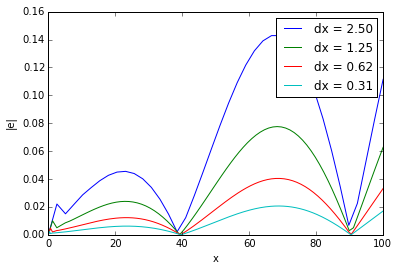

In [4]:
for k in range(len(Cest)):
    N = len(Cest[k])
    plot(linspace(0,L,N), abs(Cest[k]-Ctrue[k]), label="dx = %.2f"%(L/N))
    gca().set_ylabel('|e|')
    gca().set_xlabel('x')
legend()
e2= [norm(Cest[i]-Ctrue[i])*sqrt(L/len(Cest[i])) for i in range(len(Cest))]
e1 = [sum(abs(Cest[i]-Ctrue[i]))*(n0.Ls[0]/len(Cest[i])) for i in range(len(Cest))]
print "%d pipe results"%Np
print "  N     & M  & ||e||_1\\\\"
for k in range(len(e2)):
    print"%3d &   %5d & %.3e\\\\"%(len(Cest[k]), Ms[k], e1[k])

KCl= 0.000006
amplitude is 0.929 after 2.00 hours


(0, 1.1)

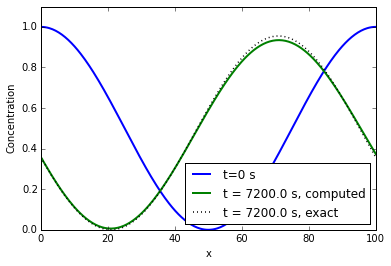

In [5]:
plot(x,c0,label="t=0 s",lw=2)
newA = abs(max(Cest[-1])-min(Cest[-1]))
#plot(x,Ctrue[-1],'r')
plot(x,Cest[-1], label="t = %.1f s, computed"%T,lw=2)
plot(x,Ctrue[-1],'k:', label="t = %.1f s, exact"%(T),lw=1.5)
gca().set_xlabel('x')
gca().set_ylabel('Concentration')
legend(loc = 'lower right')
print "KCl= %f"%KCl
print "amplitude is %.3f after %.2f hours"%(newA, T/3600.)
savefig("../Chlorine1.eps", type="eps")
ylim(0,1.1)

In [6]:
##now try it in a three-pipe case--just look for convergence
mtype = 1
A = 0.5;
B = 0.5;
kw = .45/86400.;  #m/s. from Rossman 1994 (range is .15-.45 m/day)
Np = 3


Mrs = [0.0]*Np#manning roughness coeffs
Ds = [1.]*Np      #pipe diameter (m)
L =100
oldinp = "../indata/Cltest3.inp"        #name of .inp file
jt = [1,3,1,1]
bt = [1,1,1,1]
bv = [1,0,0,0]
r = [0,1,-1,-1]
elevs = [0,0,0,0]  #junction elevations
Ls =[L]*Np
h0s = [0]*Np      #IC for h
q0s = [0]*Np      #IC for Q
h0s[0] = 10;
q0s[0]= 1.;
T = 50          #simulation time (s)
M = 40         #number of time steps
a = 10          #pressure wavespeed

Nref = 4        #number of refinements
Cest = []
Ctrue = []
Ms= []
for i in range(0,Nref):
    Ns = [20*pow(2,i)]*Np
    M = Ns[0]*10
    print "M = %d, N = %d"%(M,Ns[0])
    fn = "../indata/Cltestref%d"%i  #name of .config file
    #make new .inp and .config files called fn.inp and fn.config with desired characteristics
    #based on layout in oldinp 
    (fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
    n0= PyNetwork(fi,fc, mtype)
    M = n0.M
    Ms.append(M)
    N = n0.Ns[0]
    Clvals0 = np.ones(M+1);
    Clvals1 = np.zeros(M+1)
    n0.setClbVal(0,Clvals0)
    n0.setClbVal(1,Clvals1)
    n0.setClbVal(2,Clvals1)

    #c00 = c0[0:Nf/2]
    #c01 = c0[Nf/2:]
    c00 = np.ones(N)
    c01 = np.zeros(N)
    n0.setCl0(0,c00)
    n0.setCl0(1,c01)
    n0.setCl0(2,c01)
    for i in range(3):
        n0.setClkw(i,kw)
    dt= T/float(M)
    n0.runForwardProblem(dt)
    idx = [it(i,M,N) for i in range(0,N)]
    Cl0 = n0.Clhist(0)[idx]
    Cl1 = n0.Clhist(1)[idx]
    Cl2 = n0.Clhist(2)[idx]
    Cest.append(np.concatenate((Cl0,Cl1,Cl2)))

M = 200, N = 20
new files are ../indata/Cltestref0.inp and ../indata/Cltestref0.config
M = 400, N = 40
new files are ../indata/Cltestref1.inp and ../indata/Cltestref1.config
M = 800, N = 80
new files are ../indata/Cltestref2.inp and ../indata/Cltestref2.config
M = 1600, N = 160
new files are ../indata/Cltestref3.inp and ../indata/Cltestref3.config


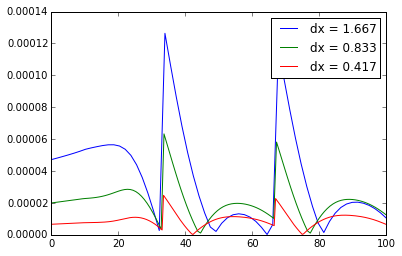

In [7]:
e2 =[]
e1 = []
for k in range(len(Cest)-1):
    Nn = len(Cest[k])
    err = Cest[k]-Cest[-1][0::pow(2,Nref-1-k)]
    dx = L/float(Nn)
    e1.append(dx*sum(abs(err)))
    e2.append(sqrt(dx)*norm(err))
    plot(linspace(0,100,Nn),abs(err), label='dx = %.3f'%(dx))
legend()

In [8]:
print "%d pipe results"%Np
print "  N   &   M & ||e||_1\\\\"
for k in range(len(e1)):
    print"%3d  & %5d  &  %.3e\\\\"%(len(Cest[k]),Ms[k], e1[k])

3 pipe results
  N   &   M & ||e||_1\\
 60  &   200  &  3.590e-03\\
120  &   400  &  2.081e-03\\
240  &   800  &  9.170e-04\\


KCl= 0.000006
amplitude change is 0.00126869 after 0.0139 hours


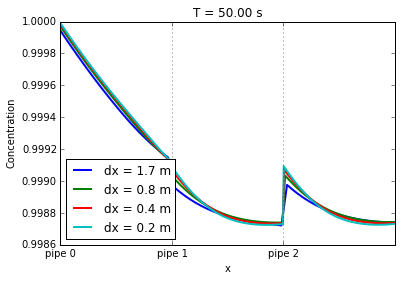

In [9]:

N = len(c0)
#plot(xf, np.concatenate((c00,c01,c01)),label='t=0 s')
for k in range(len(Cest)):
    xf = linspace(0,3, len(Cest[k]))
    plot(xf,Cest[k], label="dx = %.1f m"%(n0.Ls[0]/len(Cest[k])),lw=2)
gca().set_xlabel('x')
gca().set_xticks([0,1,2,3])
gca().set_xticklabels(['pipe 0', 'pipe 1', 'pipe 2'])
gca().xaxis.grid('True')
gca().set_ylabel('Concentration')
legend(loc = 'lower left')
print "KCl= %f"%KCl
print "amplitude change is %.8f after %.4f hours"%(abs(max(Cest[-1])-min(Cest[-1])), T/3600.)
title('T = %.2f s'%T)
savefig("/Users/lieba/Desktop/clprofile3pipes.eps", type = 'eps')

0.45


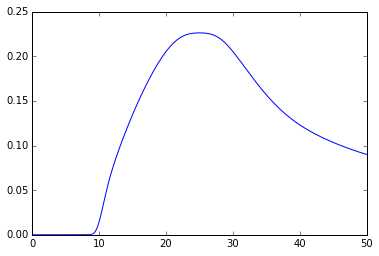

In [10]:
p0= PyPipe_ps(n0.Ns[0], n0.Ds[0],n0.Ls[0], M, a)
K=1
j = 150
qh = n0.qhist(K)
t = linspace(0,T,M+1)
plot(t,[p0.pbar(qh[n0.idx_t(0,j,n,K)],False) for n in range(M+1)])
print kw*86400

1601
1601


(0, 1.1)

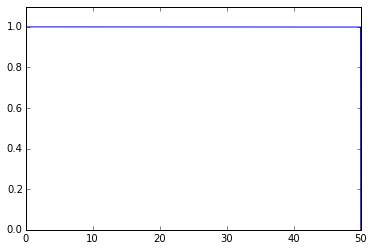

In [11]:
clh = n0.Clhist(0)
N = n0.Ns[K]
print size(t)
aa = clh[300::(N+2)]
print size(aa)
plot(t,aa)
#semilogy(t,1-aa[0:-1])
ylim(0,1.1)

In [12]:
p0= PyPipe_ps(n0.Ns[0], n0.Ds[0],n0.Ls[0], M, a)
D = n0.Ds[0]
print D
def rH(A):
    y = p0.HofA(A,False)
    theta = 2*np.arccos(1.-2*y/D)
    r = A/(D*(theta)/2.)
    print "%f %f  %f"%(y,theta,r)
    return r 

1.0


0.001779 0.168767  0.001185
0.053262 0.931538  0.034620
0.084935 1.182909  0.054357
0.111862 1.364116  0.070632
0.136183 1.511862  0.084928
0.158787 1.639442  0.097868
0.180150 1.753376  0.109788
0.200563 1.857405  0.120894
0.220224 1.953904  0.131326
0.239273 2.044487  0.141184
0.257815 2.130309  0.150541
0.275932 2.212232  0.159454
0.293686 2.290919  0.167967
0.311132 2.366894  0.176116
0.328314 2.440583  0.183931
0.345269 2.512336  0.191435
0.362028 2.582451  0.198648
0.378622 2.651181  0.205587
0.395075 2.718748  0.212266
0.411409 2.785348  0.218697
0.427646 2.851159  0.224890
0.443806 2.916341  0.230853
0.459907 2.981047  0.236594
0.475965 3.045417  0.242117
0.491999 3.109588  0.247427
0.508025 3.173693  0.252528
0.524059 3.237864  0.257422
0.540117 3.302235  0.262109
0.556218 3.366941  0.266591
0.572378 3.432124  0.270866
0.588615 3.497936  0.274933
0.604950 3.564537  0.278787
0.621403 3.632106  0.282425
0.637996 3.700838  0.285840
0.654757 3.770955  0.289024
0.671711 3.842711  0

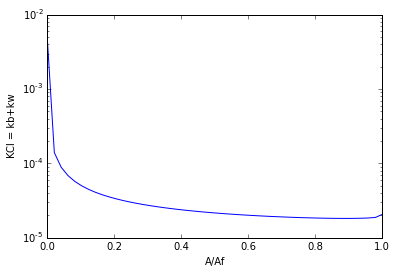

In [13]:
ys = linspace(1e-4,p0.At)
kws = [n0.getKCl(0,y,1) for y in ys]
rs = [rH(y) for y in ys]
semilogy(ys/(pi/4), kws,label='Kcl')
ylabel("KCl = kb+kw")
xlabel("A/Af")
savefig("/Users/lieba/Desktop/effectiveCLconstant.eps", type = "eps")

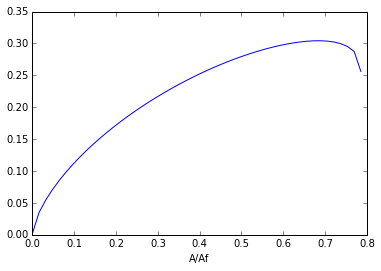

In [14]:
plot(ys,rs,label='Rh')
xlabel("A/Af")

In [110]:
print pi/4-p0.At

7.61325275891e-05


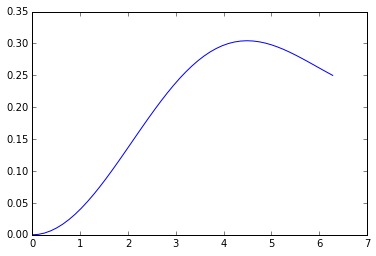

In [116]:
th = linspace(1e-4,2*pi)
Rh = D*D/8*(th-sin(th))/(D/2*th) 
plot(th,Rh)